# Re-annotate Oligo Clusters: Differentiate OPC vs Mature Oligodendrocytes

This notebook loads the processed AnnData object from the main deconvolution pipeline and re-annotates oligodendrocyte clusters into OPC (progenitor) and Oligo (mature) based on marker gene expression.

**Workflow:**
1. Load the processed AnnData object from `02.GSE185862_10X_Deconv.ipynb`
2. Identify oligodendrocyte clusters
3. Calculate marker expression (OPC vs Mature Oligo markers) per cluster
4. Re-annotate clusters based on marker expression patterns
5. Update CellType1 annotations (Oligo_M → OPC_M or Oligo_M)
6. Create expression matrix for deconvolution with updated annotations

**Marker Genes:**
- **OPC (Progenitor):** Pdgfra, Cspg4, Ptprz1, Gpr17
- **Oligo (Mature/Myelinating):** Mbp, Plp1, Mog, Apod, Klk6


In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Set scanpy settings
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

print("Libraries imported successfully!")
print(f"anndata version: {ad.__version__}")
print(f"scanpy version: {sc.__version__}")


Libraries imported successfully!
anndata version: 0.11.4
scanpy version: 1.11.5


## Step 1: Load Processed AnnData Object


In [2]:
# File paths
input_h5ad = "/home/joonho345/1_Epilepsy_RNA/scRNA_Animal/02.GSE185862_10X_Deconv/GSE185862_HIP_processed.h5ad"
output_dir = "/home/joonho345/1_Epilepsy_RNA/scRNA_Animal/02.GSE185862_10X_Deconv/00.OPC"

# Create output directories
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, "01.Annotation"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "02.Marker_Analysis"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "03.Matrix"), exist_ok=True)

print(f"Input AnnData file: {input_h5ad}")
print(f"Output directory: {output_dir}")
print(f"Directories created: ✓")

# Load AnnData object
print("\nLoading AnnData object...")
adata = ad.read_h5ad(input_h5ad)
print(f"  ✓ AnnData object loaded")
print(f"    Shape: {adata.shape} (cells × genes)")
print(f"    Cells: {adata.n_obs:,}")
print(f"    Genes: {adata.n_vars:,}")
print(f"    CellType1 distribution:")
print(adata.obs['CellType1'].value_counts())


Input AnnData file: /home/joonho345/1_Epilepsy_RNA/scRNA_Animal/02.GSE185862_10X_Deconv/GSE185862_HIP_processed.h5ad
Output directory: /home/joonho345/1_Epilepsy_RNA/scRNA_Animal/02.GSE185862_10X_Deconv/00.OPC
Directories created: ✓

Loading AnnData object...
  ✓ AnnData object loaded
    Shape: (82535, 31053) (cells × genes)
    Cells: 82,535
    Genes: 31,053
    CellType1 distribution:
CellType1
ExN_M      73990
InN_M       7106
Astro_M      534
Oligo_M      347
Micro_M      225
OPC_M        213
Endo_M       120
Name: count, dtype: int64


## Step 2: Identify Oligodendrocyte Clusters and Define Markers


In [3]:
# Define oligodendrocyte clusters (from original annotation)
oligo_clusters = ['366_Oligo', '365_Oligo', '375_Oligo', '368_Oligo', '367_Oligo', 
                  '374_Oligo', '372_Oligo', '370_Oligo', '369_Oligo', '373_Oligo', '371_Oligo']

# Define marker genes
opc_markers = ['Pdgfra', 'Cspg4', 'Ptprz1', 'Gpr17']  # OPC (Progenitor) markers
oligo_markers = ['Mbp', 'Plp1', 'Mog', 'Apod', 'Klk6']  # Oligo (Mature/Myelinating) markers

print(f"Oligodendrocyte clusters to re-annotate: {len(oligo_clusters)}")
print(f"  Clusters: {', '.join(oligo_clusters)}")
print(f"\nOPC (Progenitor) markers: {', '.join(opc_markers)}")
print(f"Oligo (Mature) markers: {', '.join(oligo_markers)}")

# Check which markers are present in the dataset
all_markers = opc_markers + oligo_markers
available_markers = [g for g in all_markers if g in adata.var_names]
missing_markers = [g for g in all_markers if g not in adata.var_names]

print(f"\nMarker gene availability:")
print(f"  Available markers: {len(available_markers)} / {len(all_markers)}")
if available_markers:
    print(f"    {', '.join(available_markers)}")
if missing_markers:
    print(f"  Missing markers: {len(missing_markers)}")
    print(f"    {', '.join(missing_markers)}")
    
# Filter to available markers only
opc_markers_available = [g for g in opc_markers if g in adata.var_names]
oligo_markers_available = [g for g in oligo_markers if g in adata.var_names]

print(f"\nUsing available markers:")
print(f"  OPC markers: {len(opc_markers_available)} - {', '.join(opc_markers_available)}")
print(f"  Oligo markers: {len(oligo_markers_available)} - {', '.join(oligo_markers_available)}")


Oligodendrocyte clusters to re-annotate: 11
  Clusters: 366_Oligo, 365_Oligo, 375_Oligo, 368_Oligo, 367_Oligo, 374_Oligo, 372_Oligo, 370_Oligo, 369_Oligo, 373_Oligo, 371_Oligo

OPC (Progenitor) markers: Pdgfra, Cspg4, Ptprz1, Gpr17
Oligo (Mature) markers: Mbp, Plp1, Mog, Apod, Klk6

Marker gene availability:
  Available markers: 9 / 9
    Pdgfra, Cspg4, Ptprz1, Gpr17, Mbp, Plp1, Mog, Apod, Klk6

Using available markers:
  OPC markers: 4 - Pdgfra, Cspg4, Ptprz1, Gpr17
  Oligo markers: 5 - Mbp, Plp1, Mog, Apod, Klk6


## Step 3: Calculate Marker Expression per Cluster


In [5]:
# Filter to only oligodendrocyte clusters
print("Filtering to oligodendrocyte clusters...")
oligo_mask = adata.obs['cluster_label'].isin(oligo_clusters)
adata_oligo = adata[oligo_mask, :].copy()
print(f"  ✓ Found {adata_oligo.n_obs:,} cells in oligodendrocyte clusters")

# Check cluster distribution
print(f"\nCluster distribution:")
print(adata_oligo.obs['cluster_label'].value_counts().sort_index())

# Calculate mean expression of markers per cluster
print("\nCalculating mean marker expression per cluster...")

# Get expression matrix (use normalized data from adata.X)
expression = adata_oligo.X
if hasattr(expression, 'toarray'):
    expression = expression.toarray()

# Calculate mean expression per cluster for OPC markers
opc_scores = {}
for cluster in oligo_clusters:
    cluster_mask = adata_oligo.obs['cluster_label'] == cluster
    if cluster_mask.sum() == 0:
        continue
    cluster_expression = expression[cluster_mask, :]
    
    # Calculate mean expression for OPC markers
    opc_mean_scores = []
    for marker in opc_markers_available:
        if marker in adata_oligo.var_names:
            marker_idx = list(adata_oligo.var_names).index(marker)
            mean_expr = np.mean(cluster_expression[:, marker_idx])
            opc_mean_scores.append(mean_expr)
    
    opc_scores[cluster] = {
        'mean_opc_score': np.mean(opc_mean_scores) if opc_mean_scores else 0,
        'individual_scores': opc_mean_scores
    }

# Calculate mean expression per cluster for Oligo markers
oligo_scores = {}
for cluster in oligo_clusters:
    cluster_mask = adata_oligo.obs['cluster_label'] == cluster
    if cluster_mask.sum() == 0:
        continue
    cluster_expression = expression[cluster_mask, :]
    
    # Calculate mean expression for Oligo markers
    oligo_mean_scores = []
    for marker in oligo_markers_available:
        if marker in adata_oligo.var_names:
            marker_idx = list(adata_oligo.var_names).index(marker)
            mean_expr = np.mean(cluster_expression[:, marker_idx])
            oligo_mean_scores.append(mean_expr)
    
    oligo_scores[cluster] = {
        'mean_oligo_score': np.mean(oligo_mean_scores) if oligo_mean_scores else 0,
        'individual_scores': oligo_mean_scores
    }

# Create summary DataFrame
summary_data = []
for cluster in oligo_clusters:
    if cluster in opc_scores and cluster in oligo_scores:
        summary_data.append({
            'cluster': cluster,
            'n_cells': (adata_oligo.obs['cluster_label'] == cluster).sum(),
            'mean_OPC_score': opc_scores[cluster]['mean_opc_score'],
            'mean_Oligo_score': oligo_scores[cluster]['mean_oligo_score'],
            'OPC_Oligo_ratio': opc_scores[cluster]['mean_opc_score'] / (oligo_scores[cluster]['mean_oligo_score'] + 1e-6)  # Avoid division by zero
        })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('OPC_Oligo_ratio', ascending=False)

print("\nMarker expression summary per cluster:")
print(summary_df.to_string(index=False))


Filtering to oligodendrocyte clusters...
  ✓ Found 560 cells in oligodendrocyte clusters

Cluster distribution:
cluster_label
365_Oligo    203
366_Oligo      4
367_Oligo      6
368_Oligo     16
369_Oligo     14
370_Oligo      3
371_Oligo      3
372_Oligo      2
373_Oligo     13
374_Oligo     21
375_Oligo    275
Name: count, dtype: int64

Calculating mean marker expression per cluster...

Marker expression summary per cluster:
  cluster  n_cells  mean_OPC_score  mean_Oligo_score  OPC_Oligo_ratio
366_Oligo        4        2.366056          0.000000     2.366056e+06
365_Oligo      203        2.146717          0.087730     2.446930e+01
367_Oligo        6        1.582308          0.833042     1.899431e+00
368_Oligo       16        1.139236          1.686804     6.753809e-01
369_Oligo       14        0.697421          2.089816     3.337237e-01
371_Oligo        3        0.356422          2.161550     1.648917e-01
370_Oligo        3        0.330831          2.324392     1.423301e-01
372_Oligo 

Creating marker expression visualizations...
  ✓ Marker expression matrix saved to: /home/joonho345/1_Epilepsy_RNA/scRNA_Animal/02.GSE185862_10X_Deconv/00.OPC/02.Marker_Analysis/marker_expression_per_cluster.txt
  ✓ Visualization saved to: /home/joonho345/1_Epilepsy_RNA/scRNA_Animal/02.GSE185862_10X_Deconv/00.OPC/02.Marker_Analysis/marker_expression_comparison.png


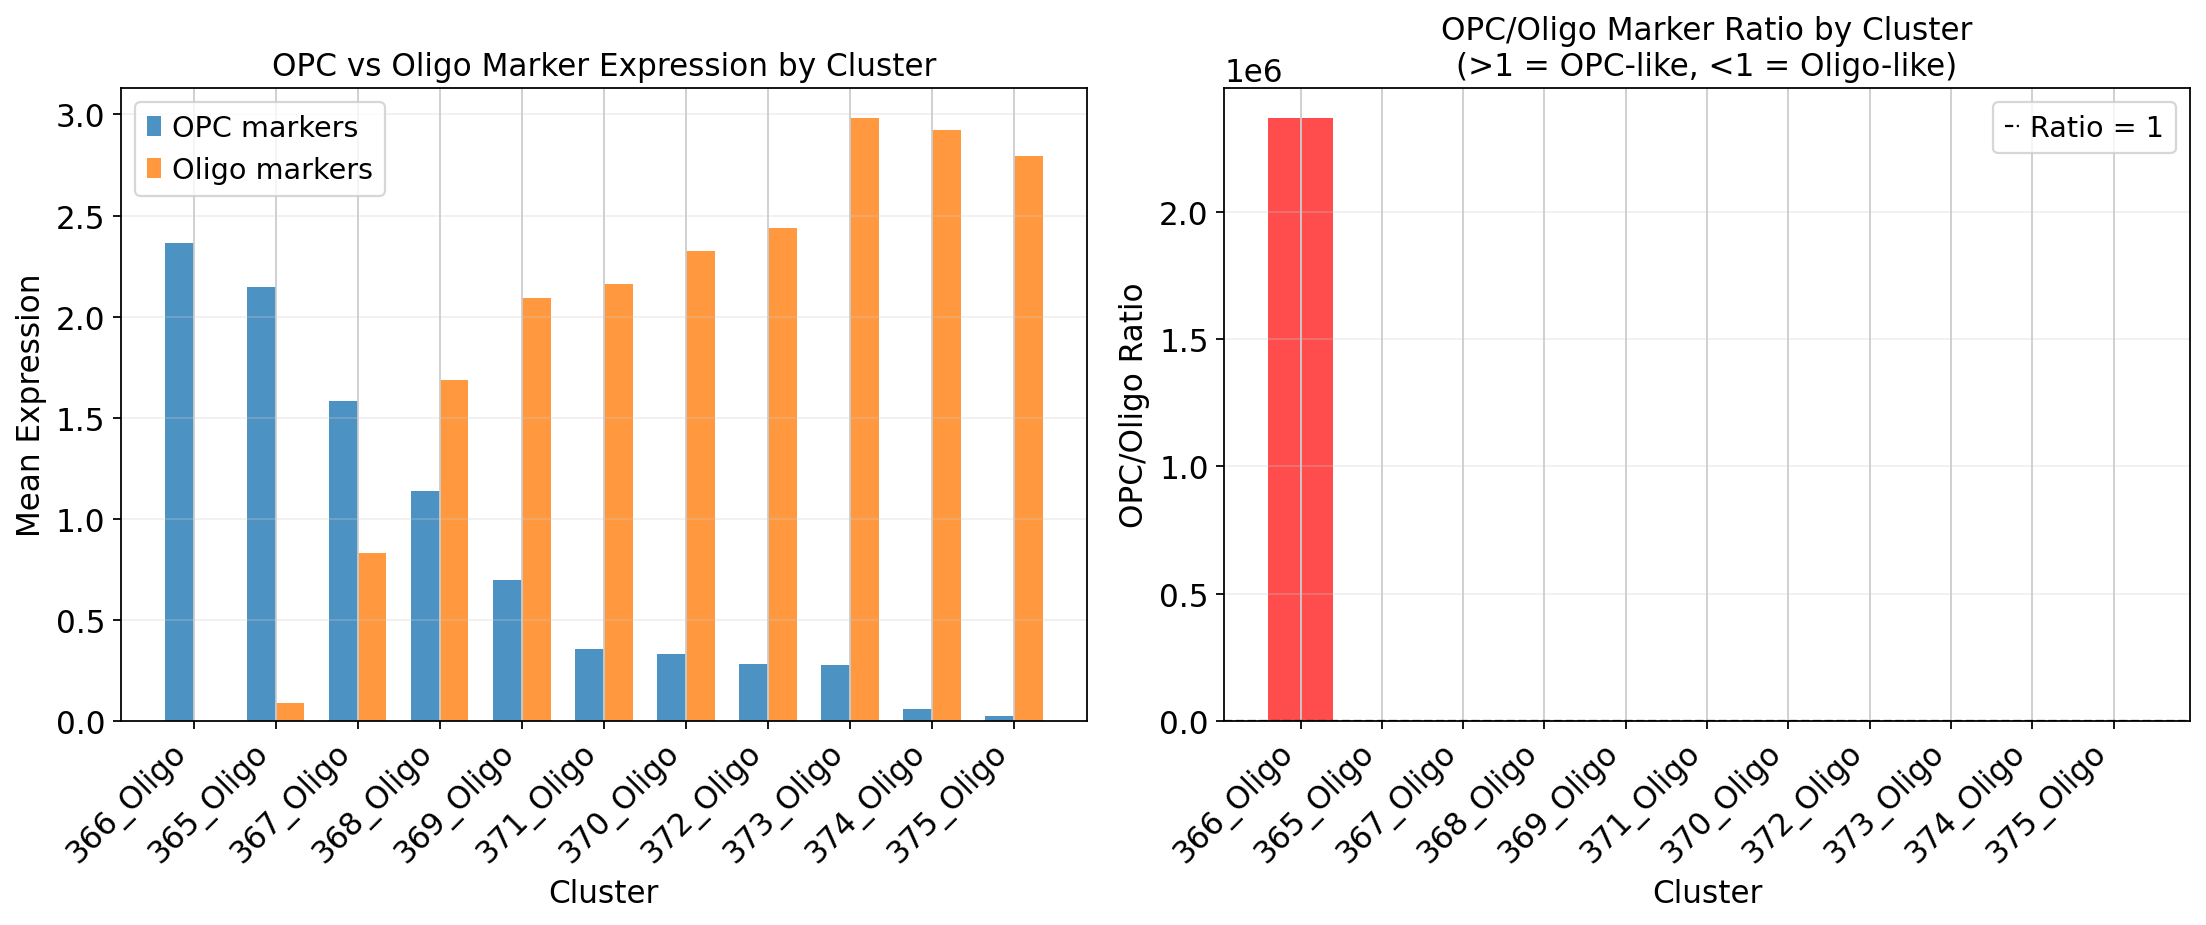

In [6]:
# Create visualization of marker expression
print("Creating marker expression visualizations...")

# Prepare data for plotting
plot_data = []
for cluster in oligo_clusters:
    cluster_mask = adata_oligo.obs['cluster_label'] == cluster
    if cluster_mask.sum() == 0:
        continue
    
    cluster_adata = adata_oligo[cluster_mask, :]
    cluster_expression = cluster_adata.X
    if hasattr(cluster_expression, 'toarray'):
        cluster_expression = cluster_expression.toarray()
    
    # Get expression for all available markers
    for marker in available_markers:
        if marker in cluster_adata.var_names:
            marker_idx = list(cluster_adata.var_names).index(marker)
            mean_expr = np.mean(cluster_expression[:, marker_idx])
            
            marker_type = 'OPC' if marker in opc_markers_available else 'Oligo'
            plot_data.append({
                'cluster': cluster,
                'marker': marker,
                'mean_expression': mean_expr,
                'marker_type': marker_type
            })

plot_df = pd.DataFrame(plot_data)

# Create heatmap-style visualization
if len(plot_df) > 0:
    # Pivot for heatmap
    pivot_df = plot_df.pivot(index='cluster', columns='marker', values='mean_expression')
    
    # Save to file
    output_path = os.path.join(output_dir, "02.Marker_Analysis", "marker_expression_per_cluster.txt")
    pivot_df.to_csv(output_path, sep='\t')
    print(f"  ✓ Marker expression matrix saved to: {output_path}")
    
    # Create visualization using matplotlib
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: OPC vs Oligo mean scores
    ax1 = axes[0]
    x_pos = np.arange(len(summary_df))
    width = 0.35
    ax1.bar(x_pos - width/2, summary_df['mean_OPC_score'], width, label='OPC markers', alpha=0.8)
    ax1.bar(x_pos + width/2, summary_df['mean_Oligo_score'], width, label='Oligo markers', alpha=0.8)
    ax1.set_xlabel('Cluster')
    ax1.set_ylabel('Mean Expression')
    ax1.set_title('OPC vs Oligo Marker Expression by Cluster')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(summary_df['cluster'], rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Plot 2: OPC/Oligo ratio
    ax2 = axes[1]
    colors = ['red' if x > 1 else 'blue' for x in summary_df['OPC_Oligo_ratio']]
    ax2.bar(x_pos, summary_df['OPC_Oligo_ratio'], color=colors, alpha=0.7)
    ax2.axhline(y=1, color='black', linestyle='--', linewidth=1, label='Ratio = 1')
    ax2.set_xlabel('Cluster')
    ax2.set_ylabel('OPC/Oligo Ratio')
    ax2.set_title('OPC/Oligo Marker Ratio by Cluster\n(>1 = OPC-like, <1 = Oligo-like)')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(summary_df['cluster'], rotation=45, ha='right')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    output_plot = os.path.join(output_dir, "02.Marker_Analysis", "marker_expression_comparison.png")
    plt.savefig(output_plot, dpi=300, bbox_inches='tight')
    print(f"  ✓ Visualization saved to: {output_plot}")
    plt.show()
else:
    print("  ⚠ No marker expression data to plot")


## Step 5: Re-annotate Clusters Based on Marker Expression


In [7]:
# Re-annotate clusters based on marker expression
# Strategy: Compare OPC vs Oligo marker scores
# If OPC score > Oligo score (ratio > 1), annotate as OPC_M
# If Oligo score >= OPC score (ratio <= 1), annotate as Oligo_M

print("Re-annotating clusters based on marker expression...")

# Create mapping of cluster to new annotation
cluster_to_annotation = {}
for _, row in summary_df.iterrows():
    cluster = row['cluster']
    opc_score = row['mean_OPC_score']
    oligo_score = row['mean_Oligo_score']
    ratio = row['OPC_Oligo_ratio']
    
    # Decision rule: Use ratio and individual scores
    # If OPC markers are stronger (ratio > 1) or if OPC score is significantly higher
    if ratio > 1.0 or opc_score > oligo_score:
        new_annotation = 'OPC_M'
    else:
        new_annotation = 'Oligo_M'
    
    cluster_to_annotation[cluster] = new_annotation
    print(f"  {cluster}: {new_annotation} (OPC={opc_score:.3f}, Oligo={oligo_score:.3f}, ratio={ratio:.3f})")

# Update annotations in the full adata object
print("\nUpdating CellType1 annotations in full dataset...")
adata.obs['CellType1_original'] = adata.obs['CellType1'].copy()  # Keep original for reference

# Check if we need to add new category (OPC_M) to the categorical
if adata.obs['CellType1'].dtype.name == 'category':
    # Get unique new annotations that need to be added
    new_annotations = set(cluster_to_annotation.values())
    current_categories = set(adata.obs['CellType1'].cat.categories)
    missing_categories = new_annotations - current_categories
    
    if missing_categories:
        print(f"  Adding new categories to CellType1: {missing_categories}")
        # Add new categories to the existing categorical
        adata.obs['CellType1'] = adata.obs['CellType1'].cat.add_categories(list(missing_categories))

# Update only oligodendrocyte cluster cells
for cluster, new_annotation in cluster_to_annotation.items():
    cluster_mask = adata.obs['cluster_label'] == cluster
    adata.obs.loc[cluster_mask, 'CellType1'] = new_annotation

# Verify the updates
print("\nUpdated CellType1 distribution:")
print(adata.obs['CellType1'].value_counts())

print("\nComparison with original:")
print("Original:")
print(adata.obs['CellType1_original'].value_counts())
print("\nUpdated:")
print(adata.obs['CellType1'].value_counts())

# Save annotation summary
annotation_summary = summary_df.copy()
annotation_summary['new_annotation'] = annotation_summary['cluster'].map(cluster_to_annotation)
annotation_summary_path = os.path.join(output_dir, "01.Annotation", "cluster_reannotation_summary.txt")
annotation_summary.to_csv(annotation_summary_path, sep='\t', index=False)
print(f"\n  ✓ Annotation summary saved to: {annotation_summary_path}")


Re-annotating clusters based on marker expression...
  366_Oligo: OPC_M (OPC=2.366, Oligo=0.000, ratio=2366056.500)
  365_Oligo: OPC_M (OPC=2.147, Oligo=0.088, ratio=24.469)
  367_Oligo: OPC_M (OPC=1.582, Oligo=0.833, ratio=1.899)
  368_Oligo: Oligo_M (OPC=1.139, Oligo=1.687, ratio=0.675)
  369_Oligo: Oligo_M (OPC=0.697, Oligo=2.090, ratio=0.334)
  371_Oligo: Oligo_M (OPC=0.356, Oligo=2.162, ratio=0.165)
  370_Oligo: Oligo_M (OPC=0.331, Oligo=2.324, ratio=0.142)
  372_Oligo: Oligo_M (OPC=0.281, Oligo=2.437, ratio=0.115)
  373_Oligo: Oligo_M (OPC=0.276, Oligo=2.981, ratio=0.092)
  374_Oligo: Oligo_M (OPC=0.058, Oligo=2.925, ratio=0.020)
  375_Oligo: Oligo_M (OPC=0.025, Oligo=2.795, ratio=0.009)

Updating CellType1 annotations in full dataset...

Updated CellType1 distribution:
CellType1
ExN_M      73990
InN_M       7106
Astro_M      534
Oligo_M      347
Micro_M      225
OPC_M        213
Endo_M       120
Name: count, dtype: int64

Comparison with original:
Original:
CellType1_original
Ex

## Step 6: Verify Final Annotations and Save Updated AnnData


In [8]:
# Verify final annotations
print("Final annotation summary:")
print("\nCellType1 distribution:")
final_dist = adata.obs['CellType1'].value_counts()
print(final_dist)

print(f"\nTotal cells: {adata.n_obs:,}")
print(f"Number of cell types: {adata.obs['CellType1'].nunique()}")

# Check that we have both OPC_M and Oligo_M
if 'OPC_M' in adata.obs['CellType1'].values:
    n_opc = (adata.obs['CellType1'] == 'OPC_M').sum()
    print(f"\n✓ OPC_M cells: {n_opc:,}")
else:
    print("\n⚠ Warning: No OPC_M cells found!")

if 'Oligo_M' in adata.obs['CellType1'].values:
    n_oligo = (adata.obs['CellType1'] == 'Oligo_M').sum()
    print(f"✓ Oligo_M cells: {n_oligo:,}")
else:
    print("⚠ Warning: No Oligo_M cells found!")

# Save updated AnnData object
output_h5ad = os.path.join(output_dir, "GSE185862_HIP_processed_OPC_annotated.h5ad")
adata.write(output_h5ad)
print(f"\n✓ Updated AnnData object saved to: {output_h5ad}")


Final annotation summary:

CellType1 distribution:
CellType1
ExN_M      73990
InN_M       7106
Astro_M      534
Oligo_M      347
Micro_M      225
OPC_M        213
Endo_M       120
Name: count, dtype: int64

Total cells: 82,535
Number of cell types: 7

✓ OPC_M cells: 213
✓ Oligo_M cells: 347

✓ Updated AnnData object saved to: /home/joonho345/1_Epilepsy_RNA/scRNA_Animal/02.GSE185862_10X_Deconv/00.OPC/GSE185862_HIP_processed_OPC_annotated.h5ad


## Step 6.5: UMAP Visualization

Visualize the clustering results using UMAP to verify the re-annotation makes spatial sense


In [9]:
# Compute UMAP if not already present
print("Checking for UMAP coordinates...")

if 'X_umap' in adata.obsm_keys():
    print("  ✓ UMAP coordinates already present in adata.obsm['X_umap']")
elif 'umap' in adata.obsm_keys():
    print("  ✓ UMAP coordinates found in adata.obsm['umap']")
    adata.obsm['X_umap'] = adata.obsm['umap']
else:
    print("  Computing UMAP...")
    # First compute PCA if needed
    if 'X_pca' not in adata.obsm_keys():
        print("    Computing PCA first...")
        sc.tl.pca(adata, svd_solver='arpack', n_comps=50)
    
    # Compute UMAP
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
    sc.tl.umap(adata, min_dist=0.5, spread=1.0)
    print("  ✓ UMAP computed")

# Verify UMAP coordinates
if 'X_umap' in adata.obsm_keys():
    umap_coords = adata.obsm['X_umap']
    print(f"\n  UMAP shape: {umap_coords.shape}")
    print(f"  UMAP range: X=[{umap_coords[:, 0].min():.2f}, {umap_coords[:, 0].max():.2f}], Y=[{umap_coords[:, 1].min():.2f}, {umap_coords[:, 1].max():.2f}]")
else:
    print("  ⚠ Warning: UMAP coordinates not found!")


Checking for UMAP coordinates...
  Computing UMAP...
    Computing PCA first...
computing PCA
    with n_comps=50
    finished (0:01:14)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:33)
  ✓ UMAP computed

  UMAP shape: (82535, 2)
  UMAP range: X=[-6.44, 22.09], Y=[-14.07, 16.24]


Creating UMAP visualizations...
  ✓ UMAP visualization saved to: /home/joonho345/1_Epilepsy_RNA/scRNA_Animal/02.GSE185862_10X_Deconv/00.OPC/02.Marker_Analysis/UMAP_clustering_verification.png


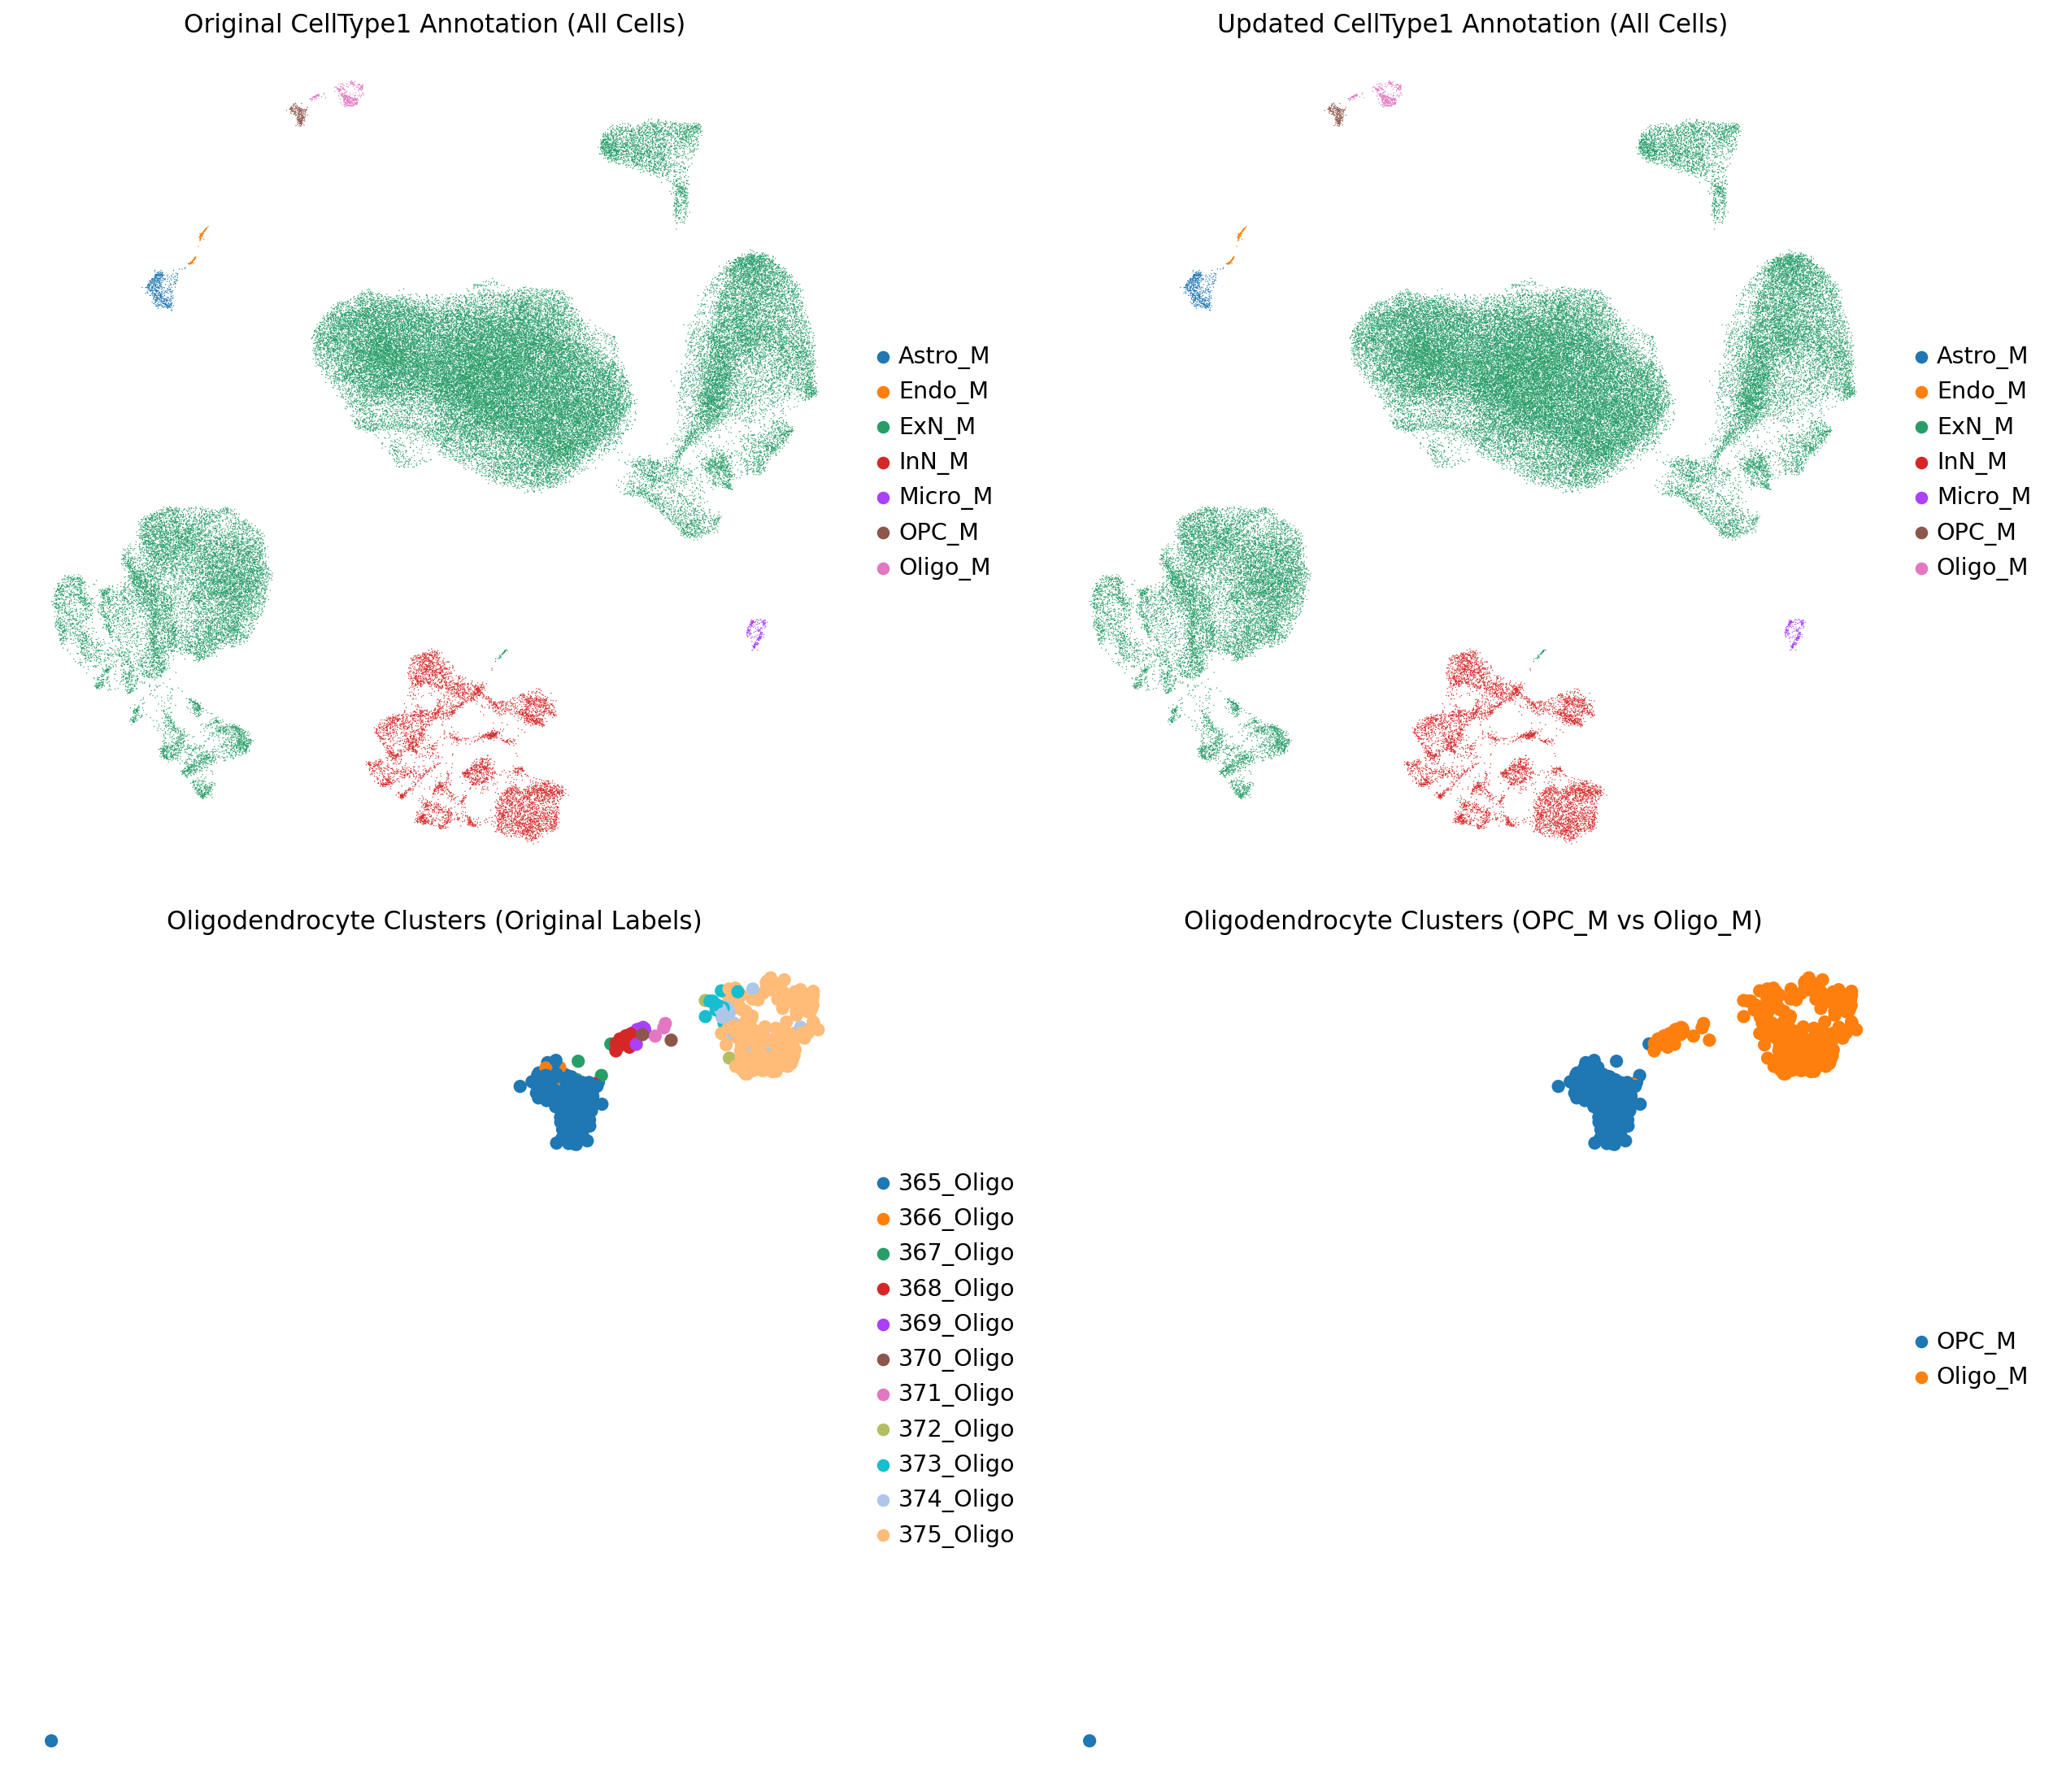

  ✓ Focused oligodendrocyte UMAP saved to: /home/joonho345/1_Epilepsy_RNA/scRNA_Animal/02.GSE185862_10X_Deconv/00.OPC/02.Marker_Analysis/UMAP_oligodendrocyte_clusters_focused.png


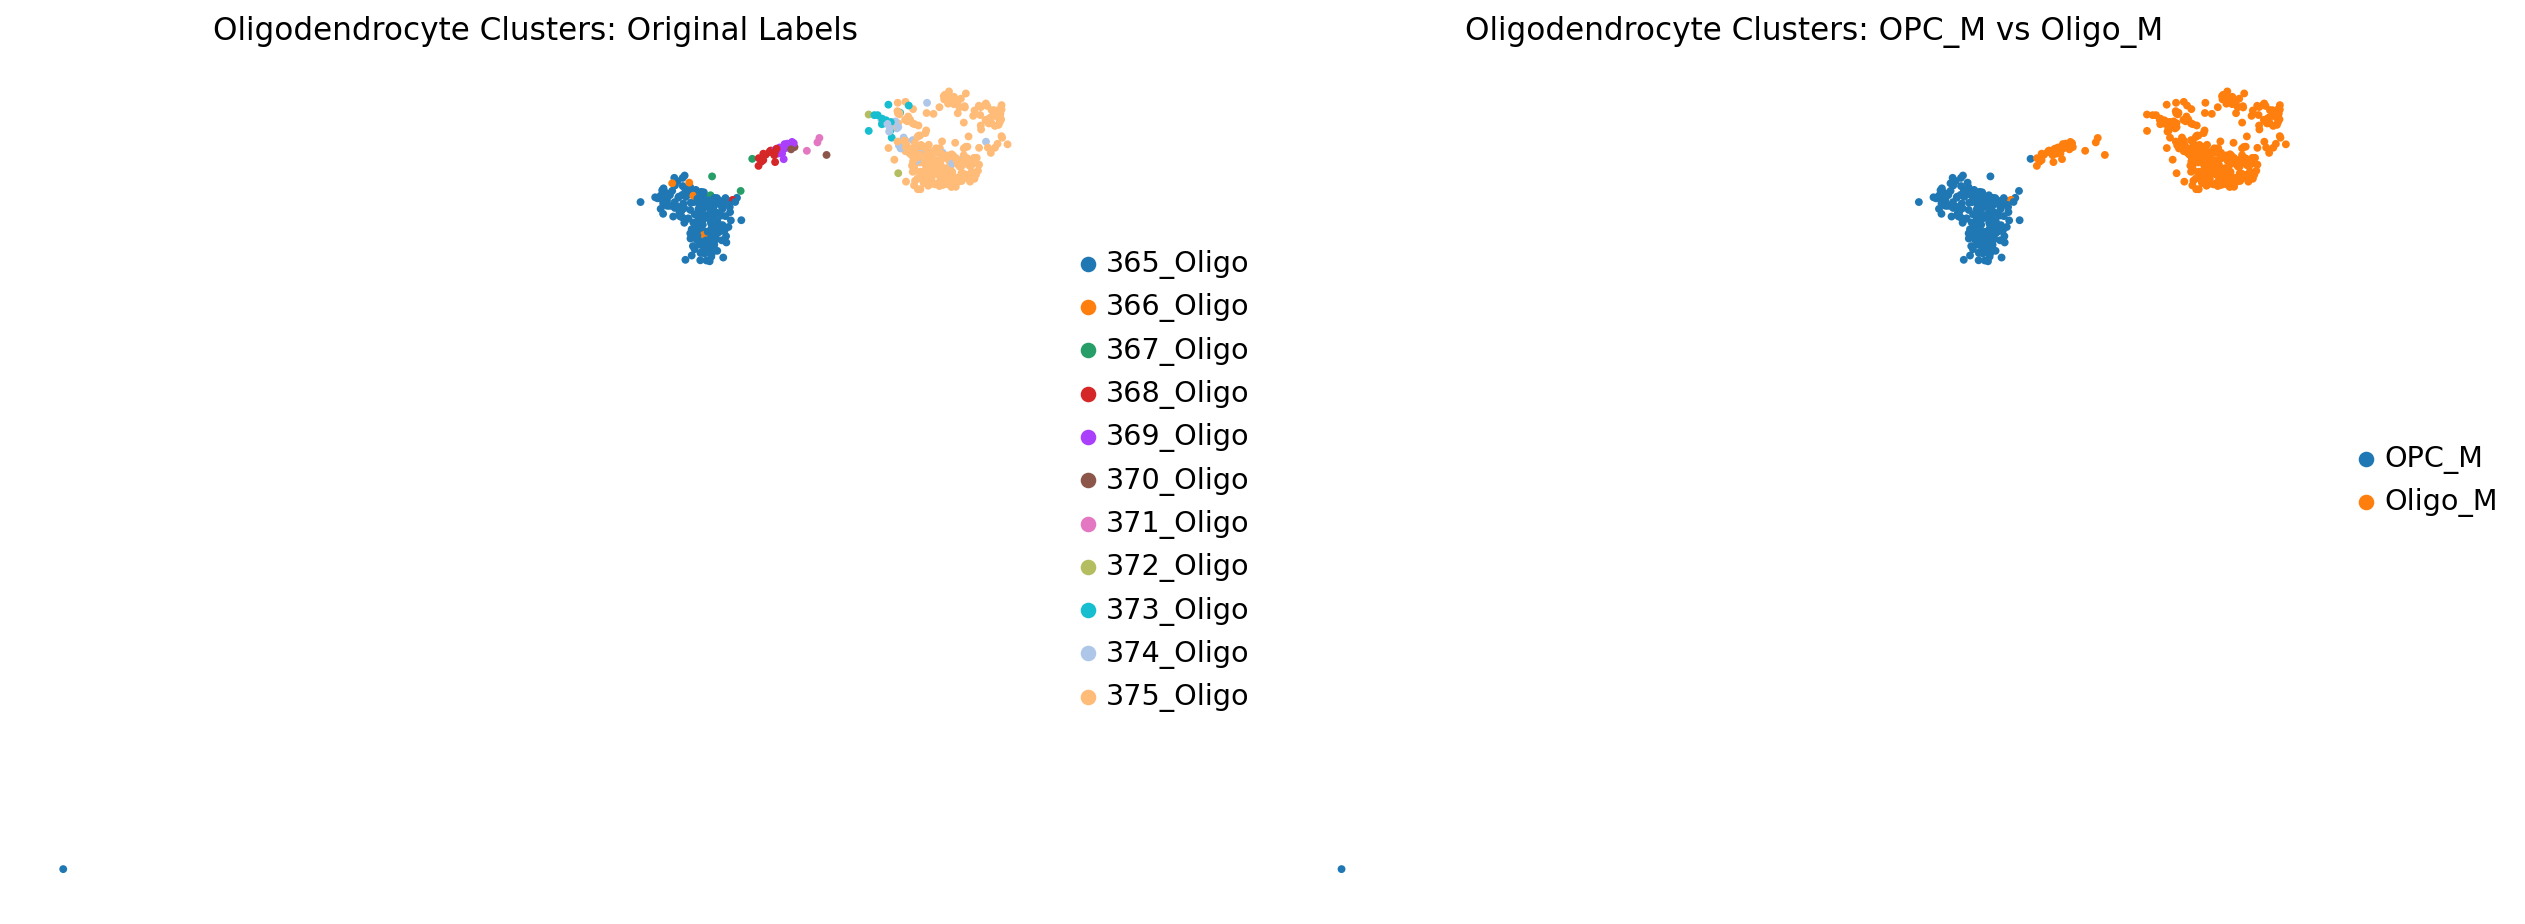

In [10]:
# Create UMAP visualizations
print("Creating UMAP visualizations...")

# Prepare oligodendrocyte subset for visualization (used in multiple plots)
oligo_mask = adata.obs['cluster_label'].isin(oligo_clusters)
adata_oligo_viz = adata[oligo_mask, :].copy()

if 'X_umap' in adata.obsm_keys():
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # Plot 1: All cells colored by original CellType1 (before re-annotation)
    ax1 = axes[0, 0]
    sc.pl.umap(adata, color='CellType1_original', ax=ax1, show=False, 
               title='Original CellType1 Annotation (All Cells)', frameon=False, legend_loc='right margin')
    
    # Plot 2: All cells colored by new CellType1 (after re-annotation)
    ax2 = axes[0, 1]
    sc.pl.umap(adata, color='CellType1', ax=ax2, show=False,
               title='Updated CellType1 Annotation (All Cells)', frameon=False, legend_loc='right margin')
    
    # Plot 3: Oligodendrocyte clusters only - colored by original cluster_label
    ax3 = axes[1, 0]
    sc.pl.umap(adata_oligo_viz, color='cluster_label', ax=ax3, show=False,
               title='Oligodendrocyte Clusters (Original Labels)', frameon=False, legend_loc='right margin')
    
    # Plot 4: Oligodendrocyte clusters only - colored by new CellType1 (OPC_M vs Oligo_M)
    ax4 = axes[1, 1]
    sc.pl.umap(adata_oligo_viz, color='CellType1', ax=ax4, show=False,
               title='Oligodendrocyte Clusters (OPC_M vs Oligo_M)', frameon=False, legend_loc='right margin')
    
    plt.tight_layout()
    output_plot = os.path.join(output_dir, "02.Marker_Analysis", "UMAP_clustering_verification.png")
    plt.savefig(output_plot, dpi=300, bbox_inches='tight')
    print(f"  ✓ UMAP visualization saved to: {output_plot}")
    plt.show()
    
    # Also create a larger focused view of just oligodendrocyte clusters
    fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
    
    # Original cluster labels
    ax1 = axes2[0]
    sc.pl.umap(adata_oligo_viz, color='cluster_label', ax=ax1, show=False,
               title='Oligodendrocyte Clusters: Original Labels', frameon=False, 
               legend_loc='right margin', size=50)
    
    # New annotations
    ax2 = axes2[1]
    sc.pl.umap(adata_oligo_viz, color='CellType1', ax=ax2, show=False,
               title='Oligodendrocyte Clusters: OPC_M vs Oligo_M', frameon=False,
               legend_loc='right margin', size=50)
    
    plt.tight_layout()
    output_plot2 = os.path.join(output_dir, "02.Marker_Analysis", "UMAP_oligodendrocyte_clusters_focused.png")
    plt.savefig(output_plot2, dpi=300, bbox_inches='tight')
    print(f"  ✓ Focused oligodendrocyte UMAP saved to: {output_plot2}")
    plt.show()
    
else:
    print("  ⚠ Cannot create UMAP plots: UMAP coordinates not available")


In [18]:
# Create additional visualization: Marker gene expression on UMAP
print("Creating marker gene expression UMAP plots...")

if 'X_umap' in adata.obsm_keys() and len(available_markers) > 0:
    # Plot OPC markers
    n_opc_markers = len(opc_markers_available)
    n_oligo_markers = len(oligo_markers_available)
    
    if n_opc_markers > 0:
        # Create FeaturePlot without gene names (similar to Deconv_plot notebook style)
        # Use ncols parameter to arrange markers in columns
        markers_to_plot = opc_markers_available[:4]  # Plot up to 4 markers
        fig_opc = sc.pl.umap(adata_oligo_viz, color=markers_to_plot, ncols=len(markers_to_plot), 
                            show=False, frameon=False, return_fig=True, 
                            legend_loc='none', use_raw=False)
        
        # Add axis labels to each subplot (keep gene names as titles)
        for idx, ax in enumerate(fig_opc.axes):
            ax.set_xlabel('UMAP 1')
            ax.set_ylabel('UMAP 2')
            # Ensure gene name is set as title (scanpy should do this automatically)
            if idx < len(markers_to_plot):
                ax.set_title(markers_to_plot[idx])
        
        # Set figure size appropriately
        fig_opc.set_size_inches(4*len(markers_to_plot), 4)
        plt.tight_layout()
        output_opc = os.path.join(output_dir, "02.Marker_Analysis", "UMAP_OPC_markers.png")
        fig_opc.savefig(output_opc, dpi=300, bbox_inches='tight')
        print(f"  ✓ OPC marker expression UMAP saved to: {output_opc}")
        plt.close()
    
    if n_oligo_markers > 0:
        # Create FeaturePlot without gene names (similar to Deconv_plot notebook style)
        # Use ncols parameter to arrange markers in columns
        markers_to_plot = oligo_markers_available[:4]  # Plot up to 4 markers
        fig_oligo = sc.pl.umap(adata_oligo_viz, color=markers_to_plot, ncols=len(markers_to_plot), 
                              show=False, frameon=False, return_fig=True, 
                              legend_loc='none', use_raw=False)
        
        # Add axis labels to each subplot (keep gene names as titles)
        for idx, ax in enumerate(fig_oligo.axes):
            ax.set_xlabel('UMAP 1')
            ax.set_ylabel('UMAP 2')
            # Ensure gene name is set as title (scanpy should do this automatically)
            if idx < len(markers_to_plot):
                ax.set_title(markers_to_plot[idx])
        
        # Set figure size appropriately
        fig_oligo.set_size_inches(4*len(markers_to_plot), 4)
        plt.tight_layout()
        output_oligo = os.path.join(output_dir, "02.Marker_Analysis", "UMAP_Oligo_markers.png")
        fig_oligo.savefig(output_oligo, dpi=300, bbox_inches='tight')
        print(f"  ✓ Oligo marker expression UMAP saved to: {output_oligo}")
        plt.close()
else:
    print("  ⚠ Cannot create marker expression plots: UMAP coordinates or markers not available")


Creating marker gene expression UMAP plots...
  ✓ OPC marker expression UMAP saved to: /home/joonho345/1_Epilepsy_RNA/scRNA_Animal/02.GSE185862_10X_Deconv/00.OPC/02.Marker_Analysis/UMAP_OPC_markers.png
  ✓ Oligo marker expression UMAP saved to: /home/joonho345/1_Epilepsy_RNA/scRNA_Animal/02.GSE185862_10X_Deconv/00.OPC/02.Marker_Analysis/UMAP_Oligo_markers.png


In [15]:
opc_markers_available

['Pdgfra', 'Cspg4', 'Ptprz1', 'Gpr17']

In [17]:
oligo_markers_available

['Mbp', 'Plp1', 'Mog', 'Apod', 'Klk6']

## Step 7: Create Expression Matrix for Deconvolution

Create expression matrix using DEGs (from original analysis) with updated cell type annotations


In [21]:
# Load DEG markers from original analysis
original_deg_path = "/home/joonho345/1_Epilepsy_RNA/scRNA_Animal/02.GSE185862_10X_Deconv/02.DEGs/GSE185862_HIP_union_markers_CellType1.txt"
print("Loading DEG markers from original analysis...")

if os.path.exists(original_deg_path):
    deg_markers = pd.read_csv(original_deg_path, header=None, sep='\t')[0].values
    print(f"  ✓ Loaded {len(deg_markers):,} DEG markers")
else:
    print(f"  ⚠ Warning: DEG markers file not found at {original_deg_path}")
    print("  Using all genes instead...")
    deg_markers = adata.var_names.values

# Filter to markers present in the dataset
deg_markers_available = [g for g in deg_markers if g in adata.var_names]
print(f"  Available DEG markers: {len(deg_markers_available):,} / {len(deg_markers):,}")

# Get expression matrix (using normalized data)
expression_matrix = adata.X
if hasattr(expression_matrix, 'toarray'):
    expression_matrix = expression_matrix.toarray()

# Filter to DEG markers only
marker_indices = np.where(np.isin(adata.var_names, deg_markers_available))[0]
expression_matrix_filtered = expression_matrix[:, marker_indices]
features_filtered = adata.var_names[marker_indices].values

print(f"\nFiltered expression matrix:")
print(f"  Shape: {expression_matrix_filtered.shape} (cells × genes)")
print(f"  Cells: {expression_matrix_filtered.shape[0]:,}")
print(f"  Genes (DEGs): {expression_matrix_filtered.shape[1]:,}")


Loading DEG markers from original analysis...
  ✓ Loaded 1,056 DEG markers
  Available DEG markers: 1,056 / 1,056

Filtered expression matrix:
  Shape: (82535, 1056) (cells × genes)
  Cells: 82,535
  Genes (DEGs): 1,056


In [22]:
# Convert to DataFrame format for output (similar to original workflow)
print("Creating expression matrix DataFrame...")

# Verify cell count
assert expression_matrix_filtered.shape[0] == adata.n_obs, f"Cell count mismatch: {expression_matrix_filtered.shape[0]} vs {adata.n_obs}"

# Convert to dense if needed
if hasattr(expression_matrix_filtered, 'toarray'):
    dense_array = expression_matrix_filtered.toarray()
else:
    dense_array = expression_matrix_filtered

# Transpose: (cells, genes) -> (genes, cells)
dense_array_T = dense_array.T

# Create DataFrame
expression_df = pd.DataFrame(
    dense_array_T,  # Shape: (genes, cells)
    index=features_filtered,  # Gene names
    columns=adata.obs_names   # Cell barcodes
)

# Add Gene column as first column
expression_df.insert(0, 'Gene', expression_df.index.values)

# Verify shape
assert expression_df.shape == (len(features_filtered), adata.n_obs + 1), \
    f"Unexpected shape: {expression_df.shape}, expected ({len(features_filtered)}, {adata.n_obs + 1})"

expression_df = expression_df.reset_index(drop=True)

print(f"  ✓ Expression matrix created")
print(f"    Shape: {expression_df.shape} (genes × columns)")
print(f"    Genes: {len(features_filtered):,}")
print(f"    Total columns: {expression_df.shape[1]:,} (1 Gene + {adata.n_obs:,} cells)")


Creating expression matrix DataFrame...
  ✓ Expression matrix created
    Shape: (1056, 82536) (genes × columns)
    Genes: 1,056
    Total columns: 82,536 (1 Gene + 82,535 cells)


In [23]:
# Save expression matrix with updated cell type annotations
print("Saving expression matrix for deconvolution...")

matrix_output_dir = os.path.join(output_dir, "03.Matrix")

# Get cell type annotations (matching the order of cells in expression_df)
celltype_annotations = adata.obs['CellType1'].values
assert len(celltype_annotations) == adata.n_obs, f"Annotation count mismatch"

# Create header: 'Gene' + cell type labels
header = ['Gene'] + celltype_annotations.tolist()
assert len(header) == expression_df.shape[1], f"Header length mismatch: {len(header)} vs {expression_df.shape[1]}"

# Output file path
output_path = os.path.join(matrix_output_dir, "GSE185862_HIP_scRNA_matrix_DEGs_CellType1_OPC.txt")

# Write header row first
import csv
with open(output_path, 'w') as f:
    f.write('\t'.join(header) + '\n')

# Append data rows (without writing DataFrame column names again)
expression_df.to_csv(output_path, mode='a', sep='\t', index=False, header=False, quoting=csv.QUOTE_NONE)

print(f"  ✓ Expression matrix saved to: {output_path}")
print(f"    Format: Tab-separated with cell type labels as headers")
print(f"    Genes (rows): {len(features_filtered):,}")
print(f"    Cells (columns): {adata.n_obs:,}")

# Also copy to parent directory
target_file = os.path.join(output_dir, "GSE185862_10X_scRNA_matrix_DEGs_CellType1_OPC.txt")
import shutil
shutil.copy2(output_path, target_file)
print(f"\n  ✓ Matrix file also copied to: {target_file}")

# Verify saved file
if os.path.exists(output_path):
    file_size = os.path.getsize(output_path) / (1024**2)  # Size in MB
    print(f"    File size: {file_size:.2f} MB")
    
    # Check first few lines
    with open(output_path, 'r') as f:
        first_line = f.readline().strip()
        header_check = first_line.split('\t')
        print(f"    Header columns: {len(header_check)}")
        print(f"    First 10 header values: {header_check[:10]}")
else:
    print(f"    ⚠ Warning: Output file not found after saving")


Saving expression matrix for deconvolution...
  ✓ Expression matrix saved to: /home/joonho345/1_Epilepsy_RNA/scRNA_Animal/02.GSE185862_10X_Deconv/00.OPC/03.Matrix/GSE185862_HIP_scRNA_matrix_DEGs_CellType1_OPC.txt
    Format: Tab-separated with cell type labels as headers
    Genes (rows): 1,056
    Cells (columns): 82,535

  ✓ Matrix file also copied to: /home/joonho345/1_Epilepsy_RNA/scRNA_Animal/02.GSE185862_10X_Deconv/00.OPC/GSE185862_10X_scRNA_matrix_DEGs_CellType1_OPC.txt
    File size: 825.04 MB
    Header columns: 82536
    First 10 header values: ['Gene', 'ExN_M', 'ExN_M', 'InN_M', 'ExN_M', 'ExN_M', 'ExN_M', 'ExN_M', 'ExN_M', 'ExN_M']


## Summary

Processing complete! The oligodendrocyte clusters have been re-annotated based on marker gene expression.


In [24]:
print("="*80)
print("PROCESSING COMPLETE!")
print("="*80)
print(f"Summary:")
print(f"  Input cells: {adata.n_obs:,}")
print(f"  Oligodendrocyte clusters analyzed: {len(oligo_clusters)}")
print(f"  Cells in oligodendrocyte clusters: {adata_oligo.n_obs:,}")
print(f"\nFinal CellType1 distribution:")
print(adata.obs['CellType1'].value_counts())
print(f"\nOutput files:")
print(f"  Updated AnnData: {output_h5ad}")
print(f"  Expression matrix: {output_path}")
print(f"  Annotation summary: {annotation_summary_path}")
print("="*80)


PROCESSING COMPLETE!
Summary:
  Input cells: 82,535
  Oligodendrocyte clusters analyzed: 11
  Cells in oligodendrocyte clusters: 560

Final CellType1 distribution:
CellType1
ExN_M      73990
InN_M       7106
Astro_M      534
Oligo_M      347
Micro_M      225
OPC_M        213
Endo_M       120
Name: count, dtype: int64

Output files:
  Updated AnnData: /home/joonho345/1_Epilepsy_RNA/scRNA_Animal/02.GSE185862_10X_Deconv/00.OPC/GSE185862_HIP_processed_OPC_annotated.h5ad
  Expression matrix: /home/joonho345/1_Epilepsy_RNA/scRNA_Animal/02.GSE185862_10X_Deconv/00.OPC/03.Matrix/GSE185862_HIP_scRNA_matrix_DEGs_CellType1_OPC.txt
  Annotation summary: /home/joonho345/1_Epilepsy_RNA/scRNA_Animal/02.GSE185862_10X_Deconv/00.OPC/01.Annotation/cluster_reannotation_summary.txt
